In [1]:
import pickle
import datasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import sys
sys.path.append('../')
import data_handler
import wandb
import pandas as pd

/n/home07/sangwonjung/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_config():
    api = wandb.Api()
    runs = api.runs('sangwonjung-Harvard University/mpr_generative')
    summary_list, config_list, name_list = [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        if run.state != 'finished':
            continue
        
        summary_list.append(run.summary._json_dict)
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
                if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append({"id":run.id})

    summary_list = pd.DataFrame(summary_list)
    config_list = pd.DataFrame(config_list)
    name_list = pd.DataFrame(name_list)

    runs_df = pd.concat([name_list, config_list, summary_list], 
                        keys=["id", "config", "summary"], axis=1)
    return runs_df

In [3]:
def filter_results_df(df, config):
    def is_config_match(row_config, target_config):
        for key, value in target_config.items():
            if key in row_config.keys():
                if row_config[key] != value:
                    return False
            else:
                continue
        return True

    # Apply the function row-wise
    matches = df['config'].apply(is_config_match, axis=1, args=(config,))
    filtered_df = df[matches]
    print(f"Found {len(filtered_df)} matching runs")
    return filtered_df

In [4]:
def extract_filename(df, param_name=None, params=None):
    if param_name is not None:
        if param_name not in df['config'].columns:
            raise ValueError(f"param_name {param_name} not in config columns")
        filename_dic = {}
        for param in params:
            idx = df['config'].query(f'{param_name} == {param}').index
            if idx.empty:
                print(f"{param_name} {param} not found in the dataframe")
                continue
            elif idx.shape[0] > 1:
                print(f"{param_name} {param} found {idx.shape[0]} runs in the dataframe")
                print(f"Using the last one")
                idx = idx[-1:]
            _run = df.loc[idx]
            date, time = _run['config']['date'].iloc[0], _run['config']['time'].iloc[0]
            _id = _run['id']['id'].iloc[0]
            filename = f'{date}/{time}_{_id}'
            filename_dic[param] = filename
    else:
        filename_dic = {}
        for idx, _run in df.iterrows():
            date, time = _run['config']['date'], _run['config']['time']
            _id = _run['id']['id']
            filename = f'{date}/{time}_{_id}'
            filename_dic[idx] = filename
    return filename_dic

# Check MPRs with the number of generated samples

## SD_14

In [5]:
config = {
    'date' : '070324',
    'query_dataset' : 'stable_bias_large',
    'target_model' : 'SD_14',
    # 'target_profession' : 'firefighter', 
    # 'group' : ['gender','age','race'],
    'retrieve':False,
}
function_classes = ['linear','dt']
groups = [['gender'], ['race'], ['gender','age'],['gender','age','race']]
pool_sizes = [10,20,50,100,200,500,1000,2000,5000,10000,15000,18000,21000]
pool_sizes = [float(i) for i in pool_sizes]
MPR_results = {}
for fc in function_classes:
    config['functionclass'] = fc    
    MPR_results[fc] = {}
    for group in groups:
        config['group'] = group
        MPR_results[fc][tuple(group)] = {}
        for profession in ['firefighter','CEO']:
            print(f'Loading {fc} {group} {profession}')
            config['target_profession'] = profession
            MPR_results[fc][tuple(group)][profession] = {}

            runs_df = load_config()
            df = filter_results_df(runs_df, config)

            param_name = 'pool_size'
            # print(df['config']['pool_size'])
            filename_dic = extract_filename(df, param_name, pool_sizes)

            for param, filename in filename_dic.items():
                with open(filename+'_MPR.pkl', 'rb') as f:
                    print(f'{filename} is loaded for the result of {param_name} = {param}')
                    MPR_results[fc][tuple(group)][profession][param] = pickle.load(f)[profession]
    # with open(filename+'_score.pkl', 'rb') as f:
        # scores[param] = pickle.load(f)
    # with open(filename+'_idx.pkl', 'rb') as f:
        # idxs[param] = pickle.load(f)
# print(df['id']['id'].tolist())

Loading linear ['gender'] firefighter
Found 6 matching runs
pool_size 10.0 not found in the dataframe
pool_size 100.0 not found in the dataframe
pool_size 200.0 not found in the dataframe
pool_size 10000.0 not found in the dataframe
pool_size 15000.0 not found in the dataframe
pool_size 18000.0 not found in the dataframe
pool_size 21000.0 not found in the dataframe
070324/0105_b6vf9ieq is loaded for the result of pool_size = 20.0
070324/0116_71dyd026 is loaded for the result of pool_size = 50.0
070324/0151_02lcqfk6 is loaded for the result of pool_size = 500.0
070324/0203_mlefkk2l is loaded for the result of pool_size = 1000.0
070324/0216_9knsqezu is loaded for the result of pool_size = 2000.0
070324/0228_ih238jtr is loaded for the result of pool_size = 5000.0
Loading linear ['gender'] CEO
Found 6 matching runs
pool_size 10.0 not found in the dataframe
pool_size 100.0 not found in the dataframe
pool_size 200.0 not found in the dataframe
pool_size 10000.0 not found in the dataframe
pool

In [6]:
group_name = {
    ('gender',) : 'g',
    ('race',) : 'r',
    ('gender','age',) : 'ga',
    ('gender','age','race',) : 'gar'
}
color_palettes = {
    'dt': plt.cm.Blues,  # Blue color palette for 'dt'
    'linear': plt.cm.Oranges  # Orange color palette for 'linear'
}

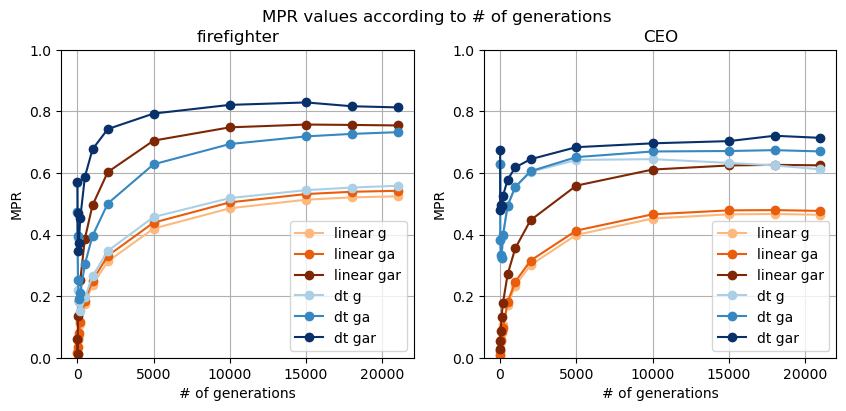

In [7]:
groups = [['gender'],  ['gender','age'],['gender','age','race']]
fig, axes = plt.subplots(1,2, figsize=(10, 4))  # Set the figure size
for i, profession in enumerate(['firefighter','CEO']):
    for fc in function_classes:
        config['functionclass'] = fc    
        cmap = color_palettes[fc]
        for j, group in enumerate(groups):
            config['group'] = group
            color_intensity = (j + 1) / len(groups)
            color = cmap(color_intensity)
            label = f'{fc} {group_name[tuple(group)]}'
            axes[i].plot(MPR_results[fc][tuple(group)][profession].keys(), MPR_results[fc][tuple(group)][profession].values(),
             marker='o', label=label, color=color)  # Plot Pool Size vs. MPR
    axes[i].set_title(profession)  # Add a title
    axes[i].set_xlabel('# of generations')  # Label the x-axis
    axes[i].set_ylabel('MPR')  # Label the yaxis
    axes[i].grid(True)  # Add a grid
    axes[i].legend()
    # axes[i].set_xscale('log')
    axes[i].set_ylim(0,1)
fig.suptitle('MPR values according to # of generations')  # Add a title
fig.show()  # Display the plots

## SD_2

In [6]:
config = {
    'date' : '070924',
    'query_dataset' : 'general',
    'target_model' : 'SD_2',
    # 'target_profession' : 'firefighter', 
    # 'group' : ['gender','age','race'],
    'retrieve':False,
}
function_classes = ['linear','dt']
groups = [['gender','age','race']]
pool_sizes = [10,20,50,100,200,500,1000,2000,5000,10000,15000,18000,21000]
pool_sizes = [float(i) for i in pool_sizes]
MPR_SD2_results = {}
for fc in function_classes:
    config['functionclass'] = fc    
    MPR_SD2_results[fc] = {}
    for group in groups:
        config['group'] = group
        MPR_SD2_results[fc][tuple(group)] = {}
        for profession in ['firefighter','CEO']:
            print(f'Loading {fc} {group} {profession}')
            config['target_profession'] = profession
            MPR_SD2_results[fc][tuple(group)][profession] = {}

            runs_df = load_config()
            df = filter_results_df(runs_df, config)

            param_name = 'pool_size'
            # print(df['config']['pool_size'])
            filename_dic = extract_filename(df, param_name, pool_sizes)

            for param, filename in filename_dic.items():
                with open(filename+'_MPR.pkl', 'rb') as f:
                    print(f'{filename} is loaded for the result of {param_name} = {param}')
                    MPR_SD2_results[fc][tuple(group)][profession][param] = pickle.load(f)[profession]
    # with open(filename+'_score.pkl', 'rb') as f:
        # scores[param] = pickle.load(f)
    # with open(filename+'_idx.pkl', 'rb') as f:
        # idxs[param] = pickle.load(f)
# print(df['id']['id'].tolist())

Loading linear ['gender', 'age', 'race'] firefighter
Found 4 matching runs
pool_size 20.0 not found in the dataframe
pool_size 50.0 not found in the dataframe
pool_size 100.0 not found in the dataframe
pool_size 200.0 not found in the dataframe
pool_size 500.0 not found in the dataframe
pool_size 1000.0 not found in the dataframe
pool_size 2000.0 not found in the dataframe
pool_size 5000.0 not found in the dataframe
pool_size 10000.0 not found in the dataframe
070924/1601_bot36in2 is loaded for the result of pool_size = 10.0
070924/1624_tc8o2lgq is loaded for the result of pool_size = 15000.0
070924/1625_snvykfik is loaded for the result of pool_size = 18000.0
070924/1626_qbekh8aw is loaded for the result of pool_size = 21000.0
Loading linear ['gender', 'age', 'race'] CEO
Found 1 matching runs
pool_size 20.0 not found in the dataframe
pool_size 50.0 not found in the dataframe
pool_size 100.0 not found in the dataframe
pool_size 200.0 not found in the dataframe
pool_size 500.0 not found

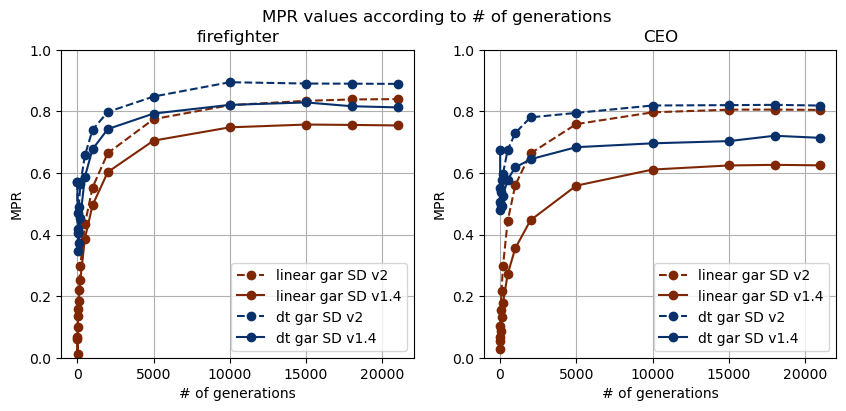

In [44]:
groups = [['gender','age','race']]
fig, axes = plt.subplots(1,2, figsize=(10, 4))  # Set the figure size
for i, profession in enumerate(['firefighter','CEO']):
    for fc in function_classes:
        config['functionclass'] = fc    
        cmap = color_palettes[fc]
        for j, group in enumerate(groups):
            config['group'] = group
            color_intensity = (j + 1) / len(groups)
            color = cmap(color_intensity)
            label = f'{fc} {group_name[tuple(group)]}'
            axes[i].plot(MPR_SD2_results[fc][tuple(group)][profession].keys(), MPR_SD2_results[fc][tuple(group)][profession].values(),
             marker='o', linestyle='--',label=label+ ' SD v2', color=color)  # Plot Pool Size vs. MPR
            axes[i].plot(MPR_results[fc][tuple(group)][profession].keys(), MPR_results[fc][tuple(group)][profession].values(),
             marker='o', label=label+' SD v1.4', color=color)  # Plot Pool Size vs. MPR            
    axes[i].set_title(profession)  # Add a title
    axes[i].set_xlabel('# of generations')  # Label the x-axis
    axes[i].set_ylabel('MPR')  # Label the yaxis
    axes[i].grid(True)  # Add a grid
    axes[i].legend()
    # axes[i].set_xscale('log')
    axes[i].set_ylim(0,1)
fig.suptitle('MPR values according to # of generations')  # Add a title
fig.show()  # Display the plots

## Ablation of use of adjective on prompts

In [7]:
config = {
    'date' : '070924',
    'query_dataset' : 'general',
    'target_model' : 'SD_14',
    'p_ver' : 'v2',
    # 'target_profession' : 'firefighter', 
    # 'group' : ['gender','age','race'],
    'retrieve':False,
}
function_classes = ['linear','dt']
groups = [['gender','age','race']]
pool_sizes = [10,20,50,100,200,500,1000,2000,5000,10000,15000,18000,21000]
pool_sizes = [float(i) for i in pool_sizes]
MPR_results_noadj = {}
for fc in function_classes:
    config['functionclass'] = fc    
    MPR_results_noadj[fc] = {}
    for group in groups:
        config['group'] = group
        MPR_results_noadj[fc][tuple(group)] = {}
        for profession in ['firefighter','CEO']:
            print(f'Loading {fc} {group} {profession}')
            config['target_profession'] = profession
            MPR_results_noadj[fc][tuple(group)][profession] = {}

            runs_df = load_config()
            df = filter_results_df(runs_df, config)

            param_name = 'pool_size'
            # print(df['config']['pool_size'])
            filename_dic = extract_filename(df, param_name, pool_sizes)

            for param, filename in filename_dic.items():
                with open(filename+'_MPR.pkl', 'rb') as f:
                    print(f'{filename} is loaded for the result of {param_name} = {param}')
                    MPR_results_noadj[fc][tuple(group)][profession][param] = pickle.load(f)[profession]
    # with open(filename+'_score.pkl', 'rb') as f:
        # scores[param] = pickle.load(f)
    # with open(filename+'_idx.pkl', 'rb') as f:
        # idxs[param] = pickle.load(f)
# print(df['id']['id'].tolist())

Loading linear ['gender', 'age', 'race'] firefighter
Found 11 matching runs
pool_size 10.0 not found in the dataframe
pool_size 20.0 not found in the dataframe
070924/1707_82ie6osl is loaded for the result of pool_size = 50.0
070924/1708_it5rdzzx is loaded for the result of pool_size = 100.0
070924/1708_qdt934ip is loaded for the result of pool_size = 200.0
070924/1709_1cc1p2if is loaded for the result of pool_size = 500.0
070924/1710_kbub3cth is loaded for the result of pool_size = 1000.0
070924/1711_uwqqukbq is loaded for the result of pool_size = 2000.0
070924/1711_y1wgdlb6 is loaded for the result of pool_size = 5000.0
070924/1712_qjlcpcsr is loaded for the result of pool_size = 10000.0
070924/1713_h5qcycwc is loaded for the result of pool_size = 15000.0
070924/1714_a3cv1c5s is loaded for the result of pool_size = 18000.0
070924/1714_pp2t9dt8 is loaded for the result of pool_size = 21000.0
Loading linear ['gender', 'age', 'race'] CEO
Found 12 matching runs
pool_size 10.0 not found 

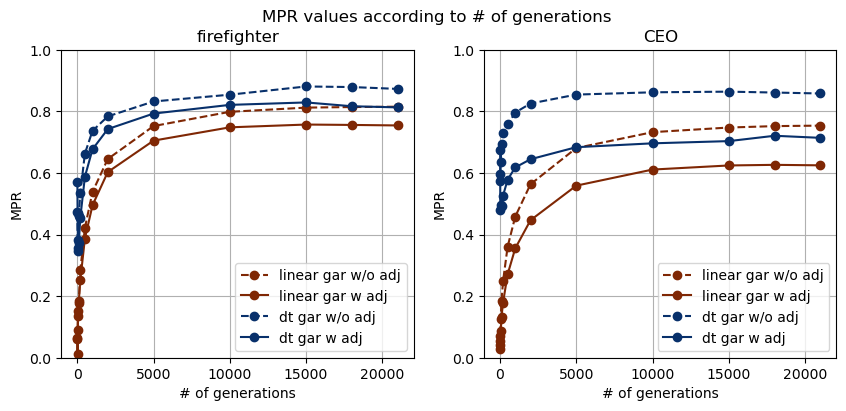

In [10]:
groups = [['gender','age','race']]
fig, axes = plt.subplots(1,2, figsize=(10, 4))  # Set the figure size
for i, profession in enumerate(['firefighter','CEO']):
    for fc in function_classes:
        config['functionclass'] = fc    
        cmap = color_palettes[fc]
        for j, group in enumerate(groups):
            config['group'] = group
            color_intensity = (j + 1) / len(groups)
            color = cmap(color_intensity)
            label = f'{fc} {group_name[tuple(group)]}'
            axes[i].plot(MPR_results_noadj[fc][tuple(group)][profession].keys(), MPR_results_noadj[fc][tuple(group)][profession].values(),
             marker='o', linestyle='--',label=label+ ' w/o adj', color=color)  # Plot Pool Size vs. MPR
            axes[i].plot(MPR_results[fc][tuple(group)][profession].keys(), MPR_results[fc][tuple(group)][profession].values(),
             marker='o', label=label+' w adj', color=color)  # Plot Pool Size vs. MPR            
    axes[i].set_title(profession)  # Add a title
    axes[i].set_xlabel('# of generations')  # Label the x-axis
    axes[i].set_ylabel('MPR')  # Label the yaxis
    axes[i].grid(True)  # Add a grid
    axes[i].legend()
    # axes[i].set_xscale('log')
    axes[i].set_ylim(0,1)
fig.suptitle('MPR values according to # of generations')  # Add a title
fig.show()  # Display the plots

## One hot vs soft group labels

In [14]:
config = {
    'date' : '071024_onehot',
    'query_dataset' : 'general',
    'target_model' : 'SD_14',
    # 'target_profession' : 'firefighter', 
    # 'group' : ['gender','age','race'],
    'retrieve':False,
}
function_classes = ['linear','dt']
groups = [['gender','age','race']]
pool_sizes = [10,20,50,100,200,500,1000,2000,5000,10000,15000,18000,21000]
pool_sizes = [float(i) for i in pool_sizes]
MPR_results_onehot = {}
for fc in function_classes:
    config['functionclass'] = fc    
    MPR_results_onehot[fc] = {}
    for group in groups:
        config['group'] = group
        MPR_results_onehot[fc][tuple(group)] = {}
        for profession in ['firefighter','CEO']:
            print(f'Loading {fc} {group} {profession}')
            config['target_profession'] = profession
            MPR_results_onehot[fc][tuple(group)][profession] = {}

            runs_df = load_config()
            df = filter_results_df(runs_df, config)
            
            param_name = 'pool_size'
            # print(df['config']['pool_size'])
            filename_dic = extract_filename(df, param_name, pool_sizes)

            for param, filename in filename_dic.items():
                with open(filename+'_MPR.pkl', 'rb') as f:
                    print(f'{filename} is loaded for the result of {param_name} = {param}')
                    MPR_results_onehot[fc][tuple(group)][profession][param] = pickle.load(f)[profession]
    # with open(filename+'_score.pkl', 'rb') as f:
        # scores[param] = pickle.load(f)
    # with open(filename+'_idx.pkl', 'rb') as f:
        # idxs[param] = pickle.load(f)
# print(df['id']['id'].tolist())

Loading linear ['gender', 'age', 'race'] firefighter
Found 27 matching runs
071024_onehot/1822_nzdjk1zz is loaded for the result of pool_size = 10.0
071024_onehot/1825_wo19x5tv is loaded for the result of pool_size = 20.0
071024_onehot/1828_zk80d0h2 is loaded for the result of pool_size = 50.0
071024_onehot/1831_x866ya30 is loaded for the result of pool_size = 100.0
071024_onehot/1834_nkehsz4c is loaded for the result of pool_size = 200.0
071024_onehot/1837_43i06d43 is loaded for the result of pool_size = 500.0
071024_onehot/1840_2o5t6qk6 is loaded for the result of pool_size = 1000.0
071024_onehot/1844_4n6ndwzn is loaded for the result of pool_size = 2000.0
071024_onehot/1847_rckgmkrm is loaded for the result of pool_size = 5000.0
071024_onehot/1850_pzvj5jwj is loaded for the result of pool_size = 10000.0
071024_onehot/1853_yx9ts12h is loaded for the result of pool_size = 15000.0
071024_onehot/1856_0s8azbwu is loaded for the result of pool_size = 18000.0
071024_onehot/1859_hjvhkqie is

In [140]:
print(df['config']['pool_size'])

650    0.002
654    0.005
658    0.010
662    0.050
666    0.100
670    0.200
674    0.300
678    0.400
682    0.500
686    0.600
690    0.700
694    0.800
698    0.900
702    1.000
Name: pool_size, dtype: float64


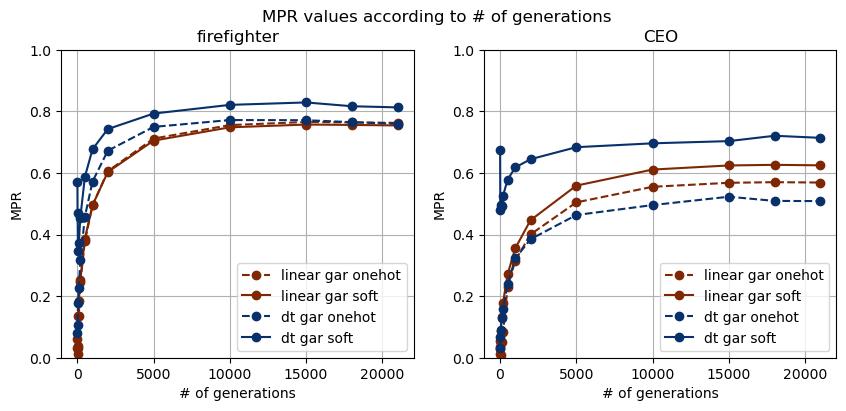

In [20]:
groups = [['gender','age','race']]
fig, axes = plt.subplots(1,2, figsize=(10, 4))  # Set the figure size
for i, profession in enumerate(['firefighter','CEO']):
    for fc in function_classes:
        config['functionclass'] = fc    
        cmap = color_palettes[fc]
        for j, group in enumerate(groups):
            config['group'] = group
            color_intensity = (j + 1) / len(groups)
            color = cmap(color_intensity)
            label = f'{fc} {group_name[tuple(group)]}'
            axes[i].plot(MPR_results_onehot[fc][tuple(group)][profession].keys(), MPR_results_onehot[fc][tuple(group)][profession].values(),
             marker='o', linestyle='--', label=label+' onehot', color=color)  # Plot Pool Size vs. MPR
            axes[i].plot(MPR_results[fc][tuple(group)][profession].keys(), MPR_results[fc][tuple(group)][profession].values(),
             marker='o', label=label+' soft', color=color)
    axes[i].set_title(profession)  # Add a title
    axes[i].set_xlabel('# of generations')  # Label the x-axis
    axes[i].set_ylabel('MPR')  # Label the yaxis
    axes[i].grid(True)  # Add a grid
    axes[i].legend()
    # axes[i].set_xscale('log')
    axes[i].set_ylim(0,1)
fig.suptitle('MPR values according to # of generations')  # Add a title
fig.show()  # Display the plots

# MPRs of MAPR with the number of pool size given a fixed k

## SD_14

In [76]:
config = {
    'date' : '070324',
    'query_dataset' : 'stable_bias_large',
    'target_model' : 'SD_14',
    'functionclass' : 'linear',
    'retrieve':True,
    'retriever':'mapr',
    'k' : 20
    # 'target_profession' : 'firefighter', 
    # 'pool_size' : [0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]#, 0.7, 0.8, 0.9, 1.0]
}

runs_df = load_config()

param_name = 'pool_size'
pool_sizes =  [0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


prorfessions = ['firefighter','CEO']
MPR_results = {}
idxs_results = {}
scores_results = {}
for profession in prorfessions:
    config['target_profession'] = profession
    df = filter_results_df(runs_df, config)
    filename_dic = extract_filename(df, param_name, pool_sizes)    
    MPR_results[profession] = {}
    idxs_results[profession] = {}
    scores_results[profession] = {}
    for param, filename in filename_dic.items():
        with open(filename+'_MPR.pkl', 'rb') as f:
            print(f'{filename} is loaded for the result of {param_name} = {param}')
            MPR_results[profession][param] = pickle.load(f)[profession]
        with open(filename+'_score.pkl', 'rb') as f:
            scores_results[profession][param] = pickle.load(f)[profession]
        with open(filename+'_idx.pkl', 'rb') as f:
            idxs_results[profession][param] = pickle.load(f)[profession]

# df['config']['pool_size']


Found 14 matching runs
070324/0045_007ff2ko is loaded for the result of pool_size = 0.002
070324/0048_d7mjfxtm is loaded for the result of pool_size = 0.005
070324/0050_ffhamu1e is loaded for the result of pool_size = 0.01
070324/0052_85tzu90n is loaded for the result of pool_size = 0.05
070324/0054_msswljxf is loaded for the result of pool_size = 0.1
070324/0057_9a0h068s is loaded for the result of pool_size = 0.2
070324/0100_qcjnr5eq is loaded for the result of pool_size = 0.3
070324/0104_u7h9m309 is loaded for the result of pool_size = 0.4
070324/0109_6ah6mufh is loaded for the result of pool_size = 0.5
070324/0114_h92m8wnv is loaded for the result of pool_size = 0.6
070324/0119_e4ojm1u9 is loaded for the result of pool_size = 0.7
070324/0126_wb7ks5q0 is loaded for the result of pool_size = 0.8
070324/0133_1friupyf is loaded for the result of pool_size = 0.9
070324/0140_kxj66qeq is loaded for the result of pool_size = 1.0
Found 14 matching runs
070324/0046_ter9ueyc is loaded for the

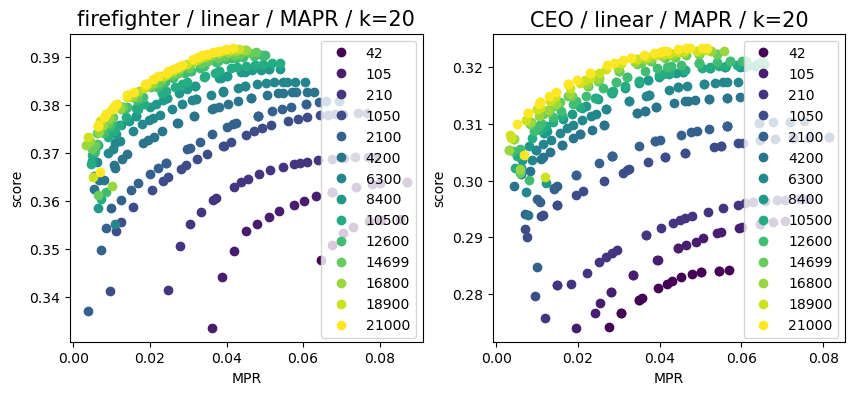

In [77]:

fig, axs = plt.subplots(1,2, figsize=(10, 4))
norm = plt.Normalize(1, len(pool_sizes))
cmap = plt.get_cmap('viridis')  # Choose a colormap

for k, profession in enumerate(prorfessions):
    ax = axs[k]
    for i, param in enumerate(pool_sizes):
        color = cmap(norm(i+1))
        flag = 0
        # for j, mpr in enumerate(MPRs[profession][i]):
        #     if j == 0:
        #         continue
        #     if (mpr-0.02) < MPRs[i]['firefighter'][j-1]:
        #         flag = j-1
        # print(flag)
        x,y = MPR_results[profession][param], scores_results[profession][param]
        x, y = np.array(x), np.array(y)
        ax.plot(x,y/20, 'o', label=f'{int(param*21000)}', color=color)
        # ax.set_xlim(0, 0.09)
        # ax.set_ylim(3.5,7)
        ax.set_xlabel('MPR')
        ax.set_ylabel('score')
        ax.legend()
    # ax.invert_yaxis()
        ax.set_title(f'{profession} / linear / MAPR / k=20', fontsize=15)

plt.show()

['0.png' '1.png' '2.png' ... '20997.png' '20998.png' '20999.png']
21000
dict_keys([0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])


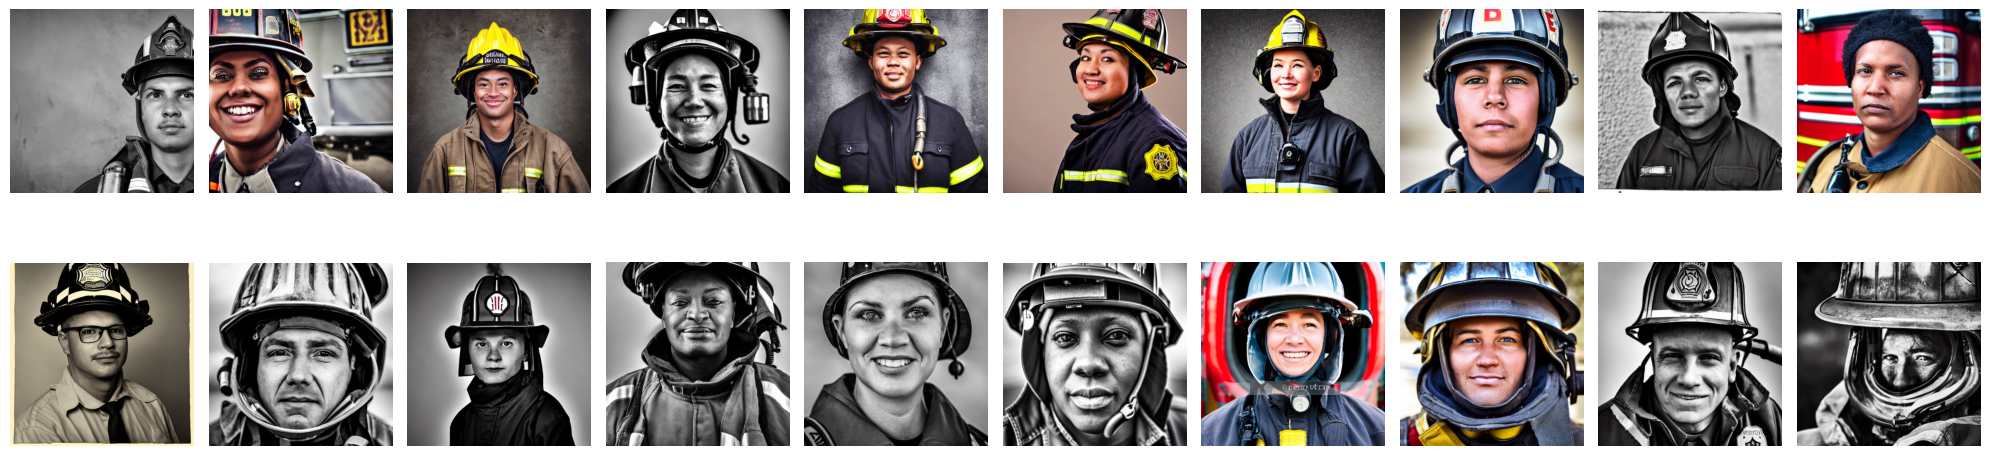

In [210]:
import os
profession = 'firefighter'
path = f'/n/holyscratch01/calmon_lab/Lab/datasets/SD_14/{profession}'
filenames = os.listdir(path)
filenames = np.array(filenames)
filenames_id = [int(f.split('.')[0]) for f in filenames]
filenames_id = np.argsort(filenames_id)
filenames = filenames[filenames_id]
# filenames = filenames[:15000]
print(filenames)

profession_set = [profession]
print(len(filenames))
# filename = self.filenames[idx]
# imagepath = os.path.join(self.path, filename)
# image = Image.open(imagepath).convert("RGB")


fig, axs = plt.subplots(2, 10, figsize=(20, 6))
print(idxs_results['firefighter'].keys())
idxs = idxs_results['firefighter'][1.0]
for i, idx in enumerate(idxs.nonzero()[0]):
    imagepath = filenames[idx]
    imagepath = os.path.join(path,imagepath)
    img = mpimg.imread(imagepath)  # Read the image from the file
    ax = axs[i // 10, i % 10]  # Determine the row and column of the subplot
    ax.imshow(img)  # Display the image
    ax.axis('off')  # Hide the axes
plt.tight_layout()
# fig.suptitle(f'{profession} images by KNN')
plt.show()

In [78]:
config = {
    'date' : '070324',
    'query_dataset' : 'stable_bias_large',
    'target_model' : 'SD_14',
    'functionclass' : 'dt',
    'retrieve':True,
    'retriever':'mapr',
    'k' : 20
    # 'target_profession' : 'firefighter', 
    # 'pool_size' : [0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]#, 0.7, 0.8, 0.9, 1.0]
}

runs_df = load_config()

param_name = 'pool_size'
pool_sizes =  [0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


prorfessions = ['firefighter','CEO']
MPR_results = {}
idxs_results = {}
scores_results = {}
for profession in prorfessions:
    config['target_profession'] = profession
    df = filter_results_df(runs_df, config)
    filename_dic = extract_filename(df, param_name, pool_sizes)    
    MPR_results[profession] = {}
    idxs_results[profession] = {}
    scores_results[profession] = {}
    for param, filename in filename_dic.items():
        with open(filename+'_MPR.pkl', 'rb') as f:
            print(f'{filename} is loaded for the result of {param_name} = {param}')
            MPR_results[profession][param] = pickle.load(f)[profession]
        with open(filename+'_score.pkl', 'rb') as f:
            scores_results[profession][param] = pickle.load(f)[profession]
        with open(filename+'_idx.pkl', 'rb') as f:
            idxs_results[profession][param] = pickle.load(f)[profession]

# df['config']['pool_size']


Found 14 matching runs
070324/0046_p3lyfb62 is loaded for the result of pool_size = 0.002
070324/0101_3g0h4ole is loaded for the result of pool_size = 0.005
070324/0120_nz6n6a64 is loaded for the result of pool_size = 0.01
070324/0152_7ks08c1w is loaded for the result of pool_size = 0.05
070324/0224_rctybw1i is loaded for the result of pool_size = 0.1
070324/0304_7x039b65 is loaded for the result of pool_size = 0.2
070324/0348_1kyj5rj8 is loaded for the result of pool_size = 0.3
070324/0449_si0nrxcr is loaded for the result of pool_size = 0.4
070324/0555_8vym7pw9 is loaded for the result of pool_size = 0.5
070324/0705_35bzhndn is loaded for the result of pool_size = 0.6
070324/0820_tsikytkg is loaded for the result of pool_size = 0.7
070324/1113_q6wknnqz is loaded for the result of pool_size = 0.8
070324/1225_em1m6i05 is loaded for the result of pool_size = 0.9
070324/1331_pu5ffaes is loaded for the result of pool_size = 1.0
Found 14 matching runs
070324/0046_5x0yhv8k is loaded for the

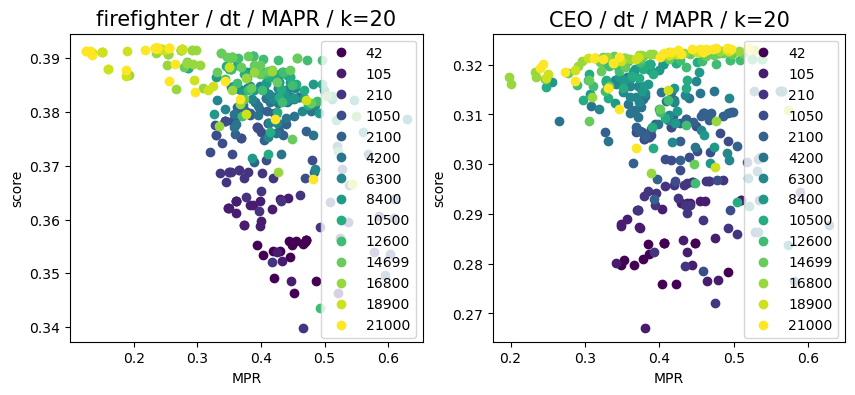

In [81]:

fig, axs = plt.subplots(1,2, figsize=(10, 4))
norm = plt.Normalize(1, len(pool_sizes))
cmap = plt.get_cmap('viridis')  # Choose a colormap

for k, profession in enumerate(prorfessions):
    ax = axs[k]
    for i, param in enumerate(pool_sizes):
        color = cmap(norm(i+1))
        flag = 0
        # for j, mpr in enumerate(MPRs[profession][i]):
        #     if j == 0:
        #         continue
        #     if (mpr-0.02) < MPRs[i]['firefighter'][j-1]:
        #         flag = j-1
        # print(flag)
        x,y = MPR_results[profession][param], scores_results[profession][param]
        x, y = np.array(x), np.array(y)
        ax.plot(x,y/20, 'o', label=f'{int(param*21000)}', color=color)
        # ax.set_xlim(0, 0.09)
        # ax.set_ylim(3.5,7)
        ax.set_xlabel('MPR')
        ax.set_ylabel('score')
        ax.legend()
    # ax.invert_yaxis()
        ax.set_title(f'{profession} / dt / MAPR / k=20', fontsize=15)

plt.show()

['0.png' '1.png' '2.png' ... '20997.png' '20998.png' '20999.png']
21000
dict_keys([0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
0.48237348237638156


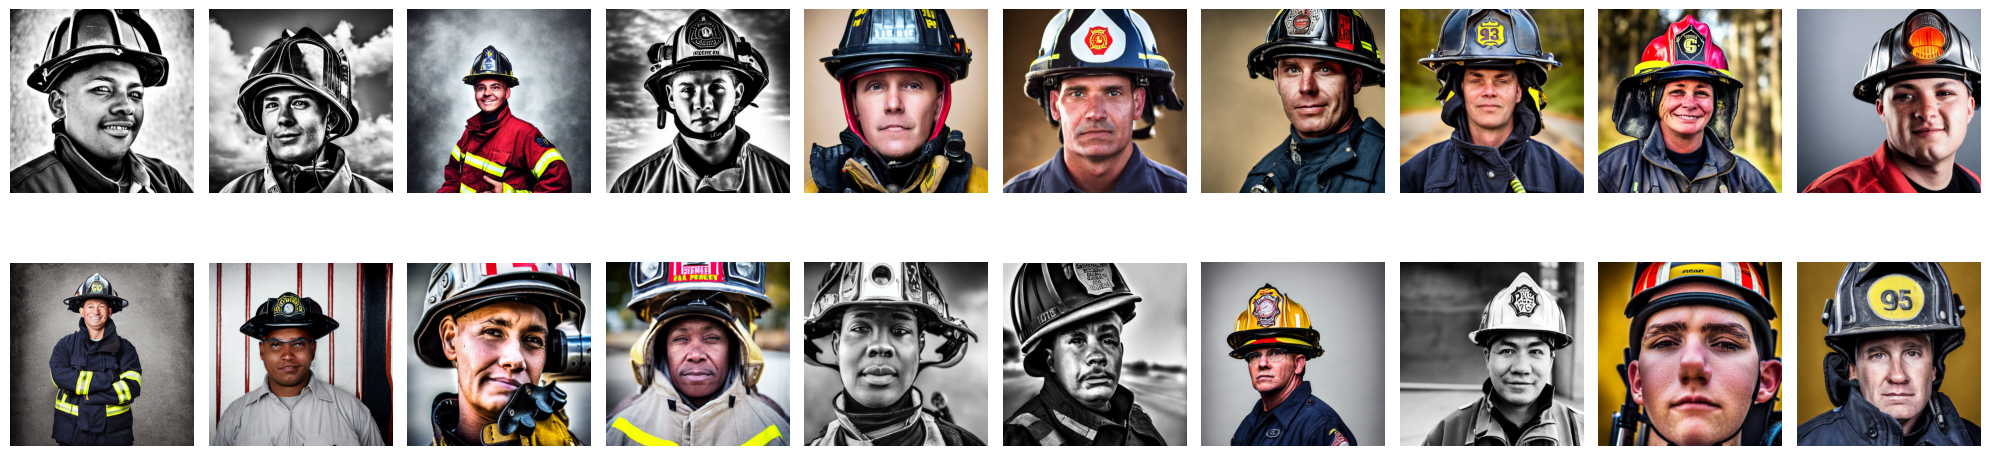

In [221]:
import os
profession = 'firefighter'
path = f'/n/holyscratch01/calmon_lab/Lab/datasets/SD_14/{profession}'
filenames = os.listdir(path)
filenames = np.array(filenames)
filenames_id = [int(f.split('.')[0]) for f in filenames]
filenames_id = np.argsort(filenames_id)
filenames = filenames[filenames_id]
# filenames = filenames[:15000]
print(filenames)

profession_set = [profession]
print(len(filenames))
# filename = self.filenames[idx]
# imagepath = os.path.join(self.path, filename)
# image = Image.open(imagepath).convert("RGB")


fig, axs = plt.subplots(2, 10, figsize=(20, 6))
print(idxs_results['firefighter'].keys())
idxs = idxs_results['firefighter'][1.0]
print(MPR_results['firefighter'][1.0][-1])
for i, idx in enumerate(idxs.nonzero()[0]):
    imagepath = filenames[idx]
    imagepath = os.path.join(path,imagepath)
    img = mpimg.imread(imagepath)  # Read the image from the file
    ax = axs[i // 10, i % 10]  # Determine the row and column of the subplot
    ax.imshow(img)  # Display the image
    ax.axis('off')  # Hide the axes
plt.tight_layout()
# fig.suptitle(f'{profession} images by KNN')
plt.show()

# Compare performances of MAPR and fairdiffusion

In [143]:
from collections import defaultdict
def rec_dd():
    return defaultdict(rec_dd)
MPR_results = rec_dd()
scores_results = rec_dd()

In [144]:
method_list = ['fairdiffusion', 'uce','mapr' ]
profession_list = ['firefighter']#, 'CEO']
group_list = [('gender',),('gender','age','race')]
fc_list = ['linear','dt']

In [145]:
t = tuple(['gender', 'age','race'])
t = tuple(['gender'])
print(t)
for g in group_list:
    print([g])

('gender',)
[('gender',)]
[('gender', 'age', 'race')]


### Fairdiffusion

In [146]:

config = {
    'date' : '070524',
    'query_dataset' : 'fairdiffusion',
    'target_model' : 'SD_14',
    # 'functionclass' : 'linear',
    # 'retrieve':True,
    # 'retriever':'mapr',
}

runs_df = load_config()
trainer = 'fairdiffusion'

for group in group_list:
    for profession in profession_list:
        for fc in fc_list:
            config['group'] = list(group)
            config['functionclass'] = fc
            # config['functionclass'] = fc
            config['target_profession'] = profession
            print(config['functionclass'], profession)
            df = filter_results_df(runs_df, config)
            filename_dic = extract_filename(df)    
            for key, value in filename_dic.items():
                with open(value+'_MPR.pkl', 'rb') as f:
                    print(f'{value} is loaded')
                    _result = pickle.load(f)
                    try:
                        MPR_results[trainer][group][profession][fc] = _result[profession]
                    except:
                        MPR_results[trainer][group][profession][fc] = _result
                with open(value+'_score.pkl', 'rb') as f:
                    _result = pickle.load(f)
                    try:
                        scores_results[trainer][group][profession][fc] = _result[profession]
                    except:
                        scores_results[trainer][group][profession][fc] = _result
            # with open(filename+'_idx.pkl', 'rb') as f:
                # idxs_results[profession][param] = pickle.load(f)[profession]

    # df['config']['pool_size']


linear firefighter
Found 0 matching runs
dt firefighter
Found 0 matching runs
linear firefighter
Found 2 matching runs
070524/1120_sv726mfa is loaded
070524/1440_l7up690k is loaded
dt firefighter
Found 2 matching runs
070524/1119_d0sjmdae is loaded
070524/1439_lk20gn7t is loaded


In [147]:
config = {
    'date' : '070524',
    'query_dataset' : 'fairdiffusion_gender',
    'target_model' : 'SD_14',
    'group' : ['gender','age','race'],
    # 'functionclass' : 'linear',
    # 'retrieve':True,
    # 'retriever':'mapr',
    'target_profession' : 'firefighter', 
}

runs_df = load_config()
profession = 'firefighter'
function_classes = ['linear','dt']
trainer = 'fairdiffusion'
group = ('gender',)

for fc in function_classes:
    config['functionclass'] = fc
    print(config['functionclass'])
    df = filter_results_df(runs_df, config)
    filename_dic = extract_filename(df)    
    MPR_results[profession][fc] = {}
    scores_results[profession][fc] = {}
    for key, value in filename_dic.items():
        with open(value+'_MPR.pkl', 'rb') as f:
            print(f'{value} is loaded')
            _result = pickle.load(f)
            try:
                MPR_results[trainer][group][profession][fc] = _result[profession]
            except:
                MPR_results[trainer][group][profession][fc] = _result
        with open(value+'_score.pkl', 'rb') as f:
            _result = pickle.load(f)
            try:
                scores_results[trainer][group][profession][fc] = _result[profession]
            except:
                scores_results[trainer][group][profession][fc] = _result        
        # with open(filename+'_idx.pkl', 'rb') as f:
            # idxs_results[profession][param] = pickle.load(f)[profession]

# df['config']['pool_size']


linear
Found 2 matching runs
070524/1122_srw0t8sb is loaded
070524/1442_prvmz2jo is loaded
dt
Found 2 matching runs
070524/1121_r2w0kn6l is loaded
070524/1441_1mss5j3t is loaded


### UCE

In [148]:

config = {
    'date' : '071024',
    'query_dataset' : 'general',
    'target_model' : 'SD_14',
    'trainer' : 'uce',
    
    # 'functionclass' : 'linear',
    # 'retrieve':True,
    # 'retriever':'mapr',
}
trainer = config['trainer']
runs_df = load_config()

for group in group_list:
    for profession in profession_list:
        for fc in fc_list:
            config['functionclass'] = fc
            config['target_profession'] = profession
            config['group'] = list(group)
            print(config['group'])
            print(config['functionclass'], profession)
            df = filter_results_df(runs_df, config)
            filename_dic = extract_filename(df)    
            for key, value in filename_dic.items():
                with open(value+'_MPR.pkl', 'rb') as f:
                    print(f'{value} is loaded')
                    MPR_results[trainer][group][profession][fc] = pickle.load(f)[profession]
                with open(value+'_score.pkl', 'rb') as f:
                    scores_results[trainer][group][profession][fc] = pickle.load(f)[profession]
        # with open(filename+'_idx.pkl', 'rb') as f:
            # idxs_results[profession][param] = pickle.load(f)[profession]

# df['config']['pool_size']


['gender']
linear firefighter
Found 1 matching runs
071024/1723_x8gxf0ea is loaded
['gender']
dt firefighter
Found 1 matching runs
071024/1724_4y2i5mw2 is loaded
['gender', 'age', 'race']
linear firefighter
Found 1 matching runs
071024/1723_g1hqm7d4 is loaded
['gender', 'age', 'race']
dt firefighter
Found 1 matching runs
071024/1725_zkeoqk1u is loaded


In [149]:
MPR_results['uce']

defaultdict(<function __main__.rec_dd()>,
            {('gender',): defaultdict(<function __main__.rec_dd()>,
                         {'firefighter': defaultdict(<function __main__.rec_dd()>,
                                      {'linear': 0.4998399902958098,
                                       'dt': 0.9999901963510665})}),
             ('gender',
              'age',
              'race'): defaultdict(<function __main__.rec_dd()>,
                         {'firefighter': defaultdict(<function __main__.rec_dd()>,
                                      {'linear': 0.7191411647220751,
                                       'dt': 0.9999829469976399})})})

linear
Found 2 matching runs
070524/1122_srw0t8sb is loaded
070524/1442_prvmz2jo is loaded
dt
Found 2 matching runs
070524/1121_r2w0kn6l is loaded
070524/1441_1mss5j3t is loaded


In [150]:
config = {
    'date' : '070524',
    'query_dataset' : 'stable_bias_large',
    'target_model' : 'SD_14',
    # 'functionclass' : 'linear',
    # 'retrieve':True,
    'retriever':'mapr',
    'k' : 10000,
    'target_profession' : 'firefighter', 
    # 'pool_size' : [0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]#, 0.7, 0.8, 0.9, 1.0]
}

runs_df = load_config()
profession = 'firefighter'
function_classes = ['linear','dt']
group = ('gender','age','race')

for fc in function_classes:
    config['functionclass'] = fc
    df = filter_results_df(runs_df, config)
    filename_dic = extract_filename(df)    
    for key, value in filename_dic.items():
        # with open(value+'_MPR.pkl', 'rb') as f:
            
            # MPR_results['mapr'][group][profession][fc] = pickle.load(f)[profession]
        with open(value+'_norMPR.pkl', 'rb') as f:
            print(f'{value} is loaded')
            MPR_results['mapr'][group][profession][fc] = np.array(pickle.load(f)[profession])
        with open(value+'_score.pkl', 'rb') as f:
            scores_results['mapr'][group][profession][fc] = np.array(pickle.load(f)[profession])
# df['config']['pool_size']

Found 1 matching runs
070524/1330_y29z01c0 is loaded
Found 0 matching runs


In [42]:
print(mapr_MPR_results['firefighter']['linear'])
print(mapr_scores_results['firefighter']['linear'])
print(mapr_norMPR_results['firefighter']['linear'])

[0.6907293006212152, 0.6669159189605186, 0.6430984173904333, 0.619275848220037, 0.5954603178580004, 0.5716240632804632, 0.5478067428853621, 0.5240099227423479, 0.5001875066770352]
[3594.6969955563545, 3593.2799796164036, 3588.8466828763485, 3581.2138763070107, 3569.6400130093098, 3553.394996136427, 3531.3804929554462, 3502.117642581463, 3458.2517802119255]
[0.7793087083253322, 0.7610510979742287, 0.743348738210913, 0.7263461327182088, 0.7100036810015025, 0.6944807759225426, 0.678773204510547, 0.6634762108938352, 0.6500575943112707]


In [151]:
color_dic = {
    'mapr' : 'blue',
    'fairdiffusion' : 'red',
    'uce' : 'green'
}

fairdiffusion ('gender',)
fairdiffusion ('gender', 'age', 'race')
uce ('gender',)
uce ('gender', 'age', 'race')
mapr ('gender',)
mapr ('gender', 'age', 'race')


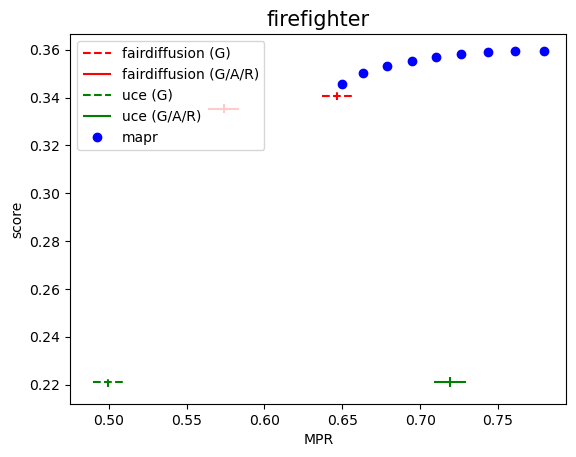

In [152]:
fig, ax = plt.subplots()
group = ('gender','age','race')

for method in method_list:
    for group in group_list:
        print(method, group)
        if method == 'mapr' and len(group) < 3:
            continue
        postfix = '(G/A/R)' if len(group) == 3 else '(G)'
        x = MPR_results[method][group]['firefighter']['linear']
        y = scores_results[method][group]['firefighter']['linear']/10000
        if method == 'mapr':
            ax.plot(x, y, 'o', label='mapr', color=color_dic[method])
        else:
            linestyle = '-' if len(group) == 3 else '--'
            ax.hlines(y, x-0.01, x+0.01, linestyle=linestyle, color=color_dic[method],label=f'{method} {postfix}')  # Draw horizontal line
            ax.vlines(x, y-0.002, y+0.002, linestyle=linestyle, color=color_dic[method])  

        # x,y = fdg_MPR_results[profession]['linear'], fdg_scores_results[profession]['linear']['firefighter']/10000
        # ax.hlines(y, x-0.01, x+0.01, color='orange',label='fairdiffusion (G)')  # Draw horizontal line
        # ax.vlines(x, y-0.002, y+0.002, color='orange') 

ax.set_xlabel('MPR')
ax.set_ylabel('score')
ax.legend()
# ax.invert_yaxis()
ax.set_title(profession, fontsize=15)
plt.show()